In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import and Explore Data

In [6]:
# Import Libraries
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_palette('pastel')
import matplotlib.pyplot as plt
import re

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gloriahwoang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Import data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_sub = pd.read_csv('./sample_submission.csv')


In [8]:
sample_sub

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [9]:
# Check for nulls
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
train.shape

(7613, 5)

In [11]:
# See the memory usage
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 2.2 MB


In [12]:
# Decrease memory usage
train['id'] = train['id'].astype('int8')
train['target'] = train['target'].astype('int8')

In [13]:
# Check new memory usage
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int8  
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int8(2), object(3)
memory usage: 2.1 MB


In [14]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,117,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,118,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,119,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,120,NaN,NaN,Police investigating after an e-bike collided ...,1


In [15]:
print('The number of unique keywords are :' , train.keyword.nunique())
print('The number of unique locations are :' , train.location.nunique())

The number of unique keywords are : 221
The number of unique locations are : 3341


**We will drop the 'locations' columns. There are way too many unique values compared to the dataset as a whole and too many null values. Let us try to keep the column 'keywords' and fill in the missing values.**

In [16]:
train = train.drop(columns = ['location'])

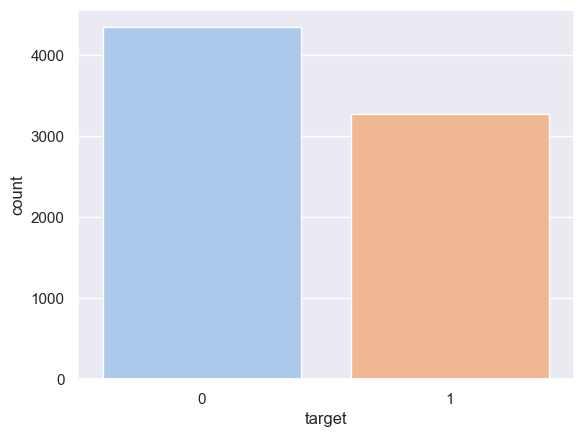

In [17]:
# Check the distribution of target
sns.countplot(x=train["target"]);

## Cleaning the Data

/var/folders/fn/p5d5tjws2g5g48w4774bp3_h0000gn/T/ipykernel_40475/2334522448.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


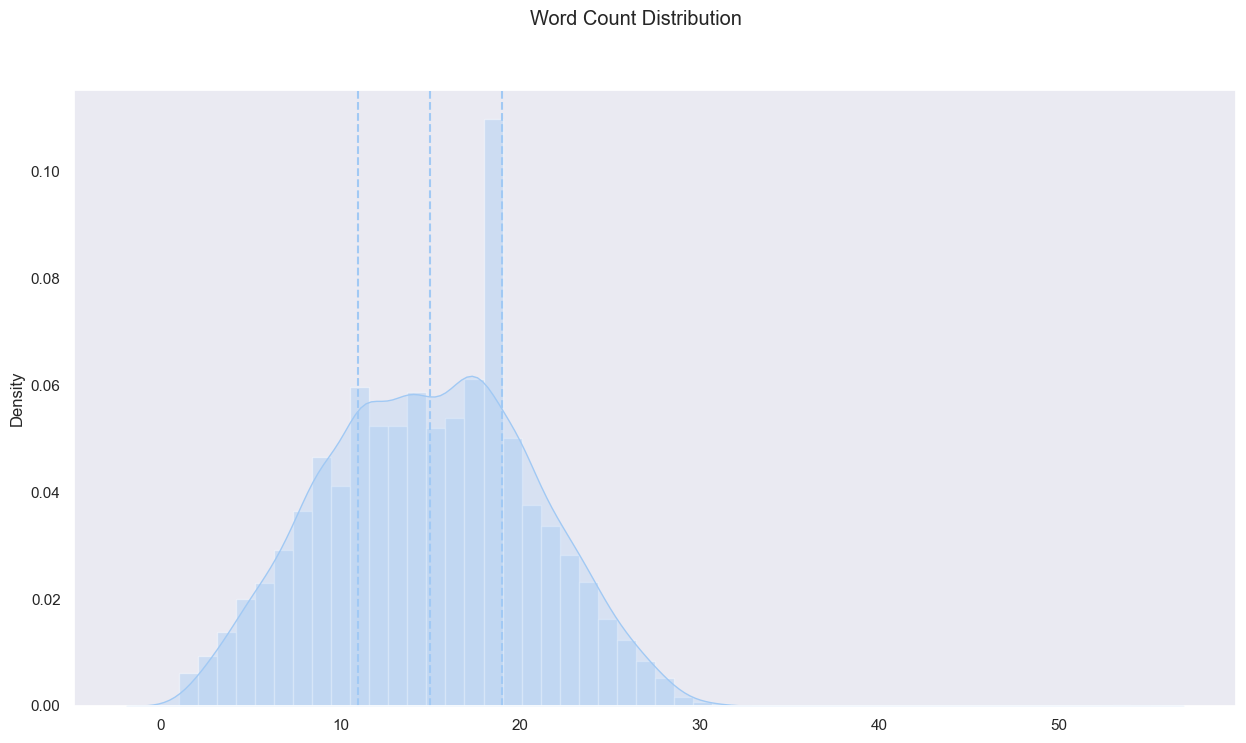

In [18]:
# Let's plot the length of the tweets
plt.figure(figsize=(15,8))
train['word_count'] = train['text'].apply(lambda x: len(x.split(" ")) )
sns.distplot(train['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(train['word_count'].describe()['25%'], ls="--")
plt.axvline(train['word_count'].describe()['50%'], ls="--")
plt.axvline(train['word_count'].describe()['75%'], ls="--")

plt.grid()
plt.suptitle("Word Count Distribution")
plt.show();

In [19]:
print("25th percentile: ", train['word_count'].describe()['25%'])
print("mean: ", train['word_count'].describe()['50%'])
print("75th percentile: ", train['word_count'].describe()['75%'])

25th percentile:  11.0
mean:  15.0
75th percentile:  19.0


In [20]:
# Clean text columns
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')


def clean_text(each_text):

    # remove URL from text
    each_text_no_url = re.sub(r"http\S+", "", each_text)
    
    # remove numbers from text
    text_no_num = re.sub(r'\d+', '', each_text_no_url)

    # tokenize each text
    word_tokens = word_tokenize(text_no_num)
    
    # remove spatial character
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))

    # remove stop words and lower
    text_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  

    # do stemming
    stemmed_text = [stemmer.stem(w) for w in text_with_no_stop_word]
    
    return " ".join(" ".join(stemmed_text).split())


train['clean_text'] = train['text'].apply(lambda x: clean_text(x) )
train['keyword'] = train['keyword'].fillna("none")
train['clean_keyword'] = train['keyword'].apply(lambda x: clean_text(x) )

In [21]:
train

,id,keyword,text,target,word_count,clean_text,clean_keyword
0,1,none,Our Deeds are the Reason of this #earthquake M...,1,13,our deed reason earthquak may allah forgiv us,none
1,4,none,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada,none
2,5,none,All residents asked to 'shelter in place' are ...,1,22,all resid ask shelter place notifi offic no ev...,none
3,6,none,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california,none
4,7,none,Just got sent this photo from Ruby #Alaska as ...,1,17,just got sent photo rubi alaska smoke wildfir ...,none
...,...,...,...,...,...,...,...
7608,117,none,Two giant cranes holding a bridge collapse int...,1,11,two giant crane hold bridg collaps nearbi home,none
7609,118,none,@aria_ahrary @TheTawniest The out of control w...,1,20,ariaahrari thetawniest the control wild fire c...,none
7610,119,none,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,m utc km s volcano hawaii,none
7611,120,none,Police investigating after an e-bike collided ...,1,19,polic investig ebik collid car littl portug eb...,none


In [22]:
# Combine column 'clean_keyword' and 'clean_text' into one
train['keyword_text'] = train['clean_keyword'] + " " + train["clean_text"]

In [23]:
train['keyword_text']

0       none our deed reason earthquak may allah forgi...
1               none forest fire near la rong sask canada
2       none all resid ask shelter place notifi offic ...
3        none peopl receiv wildfir evacu order california
4       none just got sent photo rubi alaska smoke wil...
                              ...                        
7608    none two giant crane hold bridg collaps nearbi...
7609    none ariaahrari thetawniest the control wild f...
7610                       none m utc km s volcano hawaii
7611    none polic investig ebik collid car littl port...
7612    none the latest more home raze northern califo...
Name: keyword_text, Length: 7613, dtype: object

In [24]:
train

,id,keyword,text,target,word_count,clean_text,clean_keyword,keyword_text
0,1,none,Our Deeds are the Reason of this #earthquake M...,1,13,our deed reason earthquak may allah forgiv us,none,none our deed reason earthquak may allah forgi...
1,4,none,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada,none,none forest fire near la rong sask canada
2,5,none,All residents asked to 'shelter in place' are ...,1,22,all resid ask shelter place notifi offic no ev...,none,none all resid ask shelter place notifi offic ...
3,6,none,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california,none,none peopl receiv wildfir evacu order california
4,7,none,Just got sent this photo from Ruby #Alaska as ...,1,17,just got sent photo rubi alaska smoke wildfir ...,none,none just got sent photo rubi alaska smoke wil...
...,...,...,...,...,...,...,...,...
7608,117,none,Two giant cranes holding a bridge collapse int...,1,11,two giant crane hold bridg collaps nearbi home,none,none two giant crane hold bridg collaps nearbi...
7609,118,none,@aria_ahrary @TheTawniest The out of control w...,1,20,ariaahrari thetawniest the control wild fire c...,none,none ariaahrari thetawniest the control wild f...
7610,119,none,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,m utc km s volcano hawaii,none,none m utc km s volcano hawaii
7611,120,none,Police investigating after an e-bike collided ...,1,19,polic investig ebik collid car littl portug eb...,none,none polic investig ebik collid car littl port...


In [25]:
feature = 'keyword_text'
label = "target"

# split train and test
X_train, X_test,y_train, y_test = model_selection.train_test_split(train[feature],
                                                                   train[label],
                                                                   test_size=0.3,
                                                                   random_state=0, 
                                                                   shuffle=True)

## Gradient Boosting Classifier

In [26]:
X_train_GBC = X_train.values.reshape(-1)
x_test_GBC = X_test.values.reshape(-1)

In [27]:
# Vectorize text
vectorizer = CountVectorizer()
X_train_GBC = vectorizer.fit_transform(X_train_GBC)
x_test_GBC = vectorizer.transform(x_test_GBC)

In [28]:
# Train the model
model = ensemble.GradientBoostingClassifier(learning_rate=0.1,                                            
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)
model.fit(X_train_GBC, y_train)

GradientBoostingClassifier(max_depth=9, max_features=8, min_samples_leaf=2,
                           min_samples_split=6, n_estimators=2000,
                           subsample=0.9)

In [29]:
# Evaluate the model
predicted_prob = model.predict_proba(x_test_GBC)[:,1]
predicted = model.predict(x_test_GBC)

accuracy = metrics.accuracy_score(predicted, y_test)
print("Test accuracy: ", accuracy)
print(metrics.classification_report(y_test, predicted, target_names=["0", "1"]))
print("Test F-score: ", metrics.f1_score(y_test, predicted))

Test accuracy:  0.8051663747810858
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1338
           1       0.82      0.68      0.74       946

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.81      0.80      2284

Test F-score:  0.7432198499711483


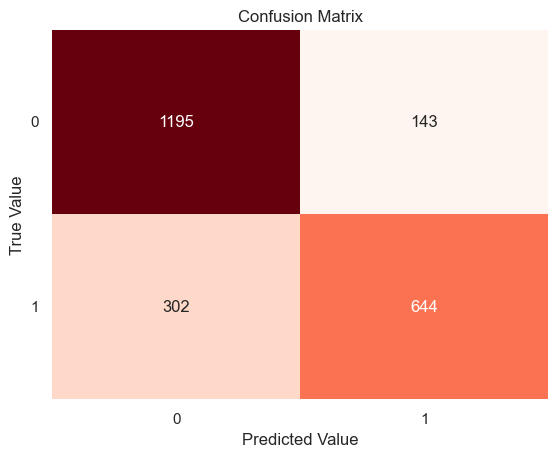

In [30]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

## Can we use GridSearch to Improve the Model?

In [47]:
from sklearn.model_selection import GridSearchCV

GBC_GridSearch = ensemble.GradientBoostingClassifier()
parameters = {"learning_rate": [0.01, 0.1, 0.2],
              'n_estimators': np.arange(800,2000,400),
              'max_depth': np.arange(4,10,2),
              'min_samples_split': np.arange(3,6,1),
              'min_samples_leaf': np.arange(1,3,1),
              'max_features': np.arange(4,12,2),
              'subsample': np.arange(0.7, 0.9 ,0.1)
              }

# defining parameter range
grid = GridSearchCV(GBC_GridSearch, parameters, cv=3, scoring='accuracy', return_train_score=True,verbose=1)
# fitting the model for grid search
grid.fit(X_train_GBC, y_train)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': array([4, 6, 8]),
                         'max_features': array([ 4,  6,  8, 10]),
                         'min_samples_leaf': array([1, 2]),
                         'min_samples_split': array([3, 4, 5]),
                         'n_estimators': array([ 800, 1200, 1600]),
                         'subsample': array([0.7, 0.8, 0.9])},
             return_train_score=True, scoring='accuracy', verbose=1)

In [48]:
print(grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1600, 'subsample': 0.7999999999999999}


Test accuracy:  0.8069176882661997
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1338
           1       0.82      0.68      0.74       946

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.81      0.80      2284

Test F-score:  0.7443478260869566


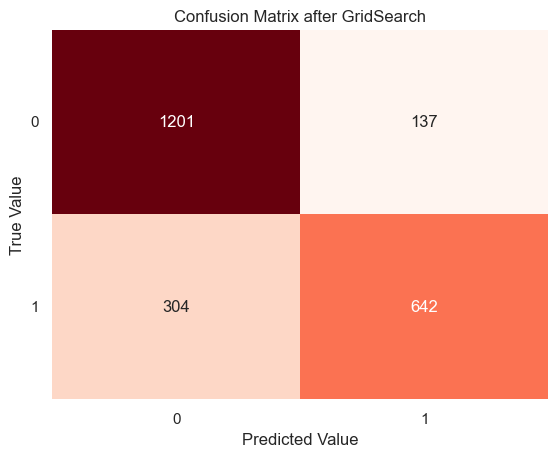

In [49]:
# Evaluate the model
predicted_prob_grid = grid.predict_proba(x_test_GBC)[:,1]
predicted_grid = grid.predict(x_test_GBC)

accuracy_grid = metrics.accuracy_score(predicted_grid, y_test)
print("Test accuracy: ", accuracy_grid)
print(metrics.classification_report(y_test, predicted_grid, target_names=["0", "1"]))
print("Test F-score: ", metrics.f1_score(y_test, predicted_grid))

# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, predicted_grid)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix after GridSearch")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

# XG Boost

In [50]:
import xgboost
from xgboost import XGBClassifier

my_model = XGBClassifier()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train_GBC, y_train, verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [51]:
# make predictions
predicted_XGBoost = my_model.predict(x_test_GBC)

In [52]:
len(predicted_XGBoost)

2284

In [53]:
predicted_XGBoost

array([0, 0, 0, ..., 0, 1, 1])

In [54]:
accuracy_XGBoost = metrics.accuracy_score(predicted_XGBoost, y_test)
print("Test accuracy: ", accuracy_XGBoost)
print(metrics.classification_report(y_test, predicted_XGBoost, target_names=["0", "1"]))
print("Test F-score: ", metrics.f1_score(y_test, predicted_XGBoost))

Test accuracy:  0.7959719789842382
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1338
           1       0.83      0.64      0.72       946

    accuracy                           0.80      2284
   macro avg       0.80      0.77      0.78      2284
weighted avg       0.80      0.80      0.79      2284

Test F-score:  0.7219570405727924


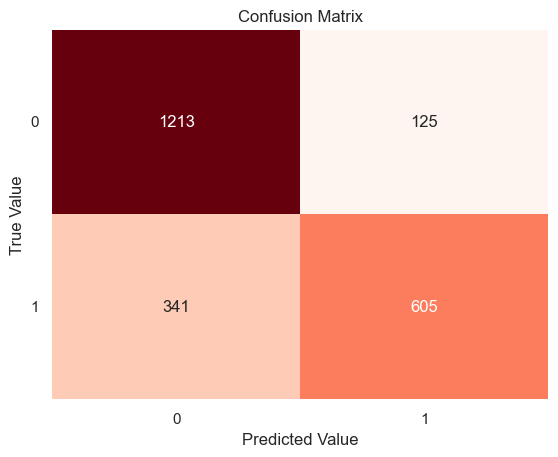

In [55]:
# Plot confusion matrix
conf_matrix_XG = metrics.confusion_matrix(y_test, predicted_XGBoost)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix_XG, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

## Can we use GridSearch to Improve the Model?

In [57]:
XGB_GridSearch = XGBClassifier()
XGB_parameters = {"learning_rate": [0.1, 0.01, 0.2],
              'n_estimators': np.arange(800,2000,400),
              'max_depth': np.arange(4,10,2),
              'subsample': np.arange(0.7,0.9,0.1),
              'colsample_bytree': np.arange(0.7,0.9,0.1),
              'reg_alpha': np.arange(0.4,0.8,0.2),
              'reg_lambda': np.arange(0.4,0.8,0.2)
              }
    
# defining parameter range
XGB_grid = GridSearchCV(XGB_GridSearch, XGB_parameters, cv=3, scoring='accuracy', return_train_score=True,verbose=1)
# fitting the model for grid search
XGB_grid.fit(X_train_GBC, y_train)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': array([0.7, 0.8, 0.9]),
                         'learning_rate': [0.1, 0.01, 0.2],
                         'max_depth': array([4, 6, 8]),
                         'n_estimators': array([ 800, 1200, 1600]),
                         'reg_alpha': array([0.4, 0.6]),
                         'reg_lambda': array([0.4, 0.6]),
                         'subsample': array([0.7, 0.8, 0.9])},
             return_train_score=True, scoring='accuracy', verbose=1)

In [58]:
print(XGB_grid.best_params_)

{'colsample_bytree': 0.8999999999999999, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 800, 'reg_alpha': 0.4, 'reg_lambda': 0.4, 'subsample': 0.8999999999999999}


Test accuracy:  0.7959719789842382
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1338
           1       0.80      0.68      0.73       946

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.78      2284
weighted avg       0.80      0.80      0.79      2284

Test F-score:  0.7331042382588775


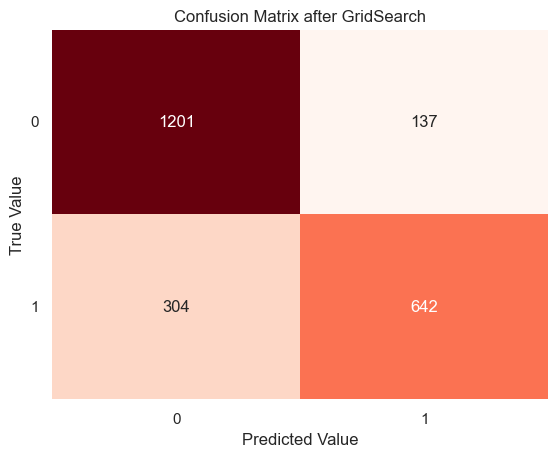

In [59]:
# Evaluate the model
XGB_predicted_prob_grid = XGB_grid.predict_proba(x_test_GBC)[:,1]
XGB_predicted_grid = XGB_grid.predict(x_test_GBC)

XGB_accuracy_grid = metrics.accuracy_score(XGB_predicted_grid, y_test)
print("Test accuracy: ", XGB_accuracy_grid)
print(metrics.classification_report(y_test, XGB_predicted_grid, target_names=["0", "1"]))
print("Test F-score: ", metrics.f1_score(y_test, XGB_predicted_grid))

# Plot confusion matrix
XGB_conf_matrix = metrics.confusion_matrix(y_test, XGB_predicted_grid)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix after GridSearch")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()